# 09wk-2: (생성모형) – Generative Adversarial Network (GAN)

## 1. Imports

In [1]:
import torch 
import torchvision
import matplotlib.pyplot as plt 

## 2. 주요 코드 등

## 3. GAN (Goodfellow el al. 2014) Intro

### **A. 잡썰**

`-` 저자 : 이안 굿펠로우

* 지도교수가 요수아 벤지오. 천재임


`-` 교수님이 개쩐다고 생각했던 논문

* https://arxiv.org/abs/1406.2661

`-` 최근 10년간 머신러닝 분야에서 가장 혁신적인 아이디어이다. (얀 르쿤. 2014)

### **B. GAN의 원리**

`-` GAN은 경찰과 위조지폐범이 서로 선의의(?) 경쟁을 통하여 발전하는 모형으로 설명할 수 있다.

> 서로 적대적인(Adversarial) 네트워크(Network)를 동시에 학습시커 가짜 이미지를 만든다(Generate)

`-` 무식한 상황극...

* 위조범 : 가짜 돈을 만들어서 부자가 돼야지! (가짜 돈을 그림)
* 경찰 : (위조범이 만든 돈을 보고) 이건 가짜다!
* 위조범 : 더 정교하게 만들어야지...(loss가 증가하면서 더 정교한 걸 만들려고 노력)
* 경찰 : 이건 진짠가...? -> 상사에게 혼남(얘도 loss 증가) -> 판별능력 업그레이드 -> 이건 가짜다!
* 위조범 : 더 정교하게...
* 경찰 : 더 판별능력을 업그레이드...

...반복...

> 굉장히 우수한 경찰조차도 진짜와 가짜를 구분하지 못할 때(진짜 이미지를 0.5의 확률로만 진짜라고 말할 때 == 가짜 이미지를 0.5의 확률로만 가짜라고 말할 때) 학습을 멈춘다.

### **C. 생성모형이란? (쉬운 설명)**

`-` 사진 속에 들어있는 동물이 개인지 고양이인지를 맞출 수 있는 기계와, 개와 고양이를 그릴 수 있는 기계 중 어떤 것이 더 시각정보에 대한 이해가 깊다고 볼 수 있는가?

> 진정으로 인공지능이 이미지자료를 이해했다면, 이미지를 만들수도 있어야 한다 -> 이미지를 생성하는 모형을 만들어보자 -> 성공


`-` 뭘 분류하려는 목적을 가진 게 판별모형이면 <-> 뭘 만들려는 목적을 가진 게 생성모형이고, **생성모형이 더 우수하다.**

### **D. 생성모형이란? 통계학과 버전의 설명**

`-` 이미지 $\bf X$가 주어졌을 경우, 라벨을 $y$라고 하자.

> 이미지를 보고 라벨을 맞추는 일은 $P(y|\bf X)$에 관심이 있다고 볼 수 있다 -> 판별모형
>
> 이미지를 생성하는 일은 $P({\bf X}, y)$에 관심이 있는 것이다 -> 생성모형, 결합분포의 이해


`-` 데이터의 생성확률 $P({\bf X}, y)$을 알면 클래스의 사후확률 $P(y|\bf X)$를 알 수 있음. 하지만 역은 불가능


$$P(y|\bf X) = \frac{P({\bf X}, y)}{P({\bf X})} = \frac{P({\bf X}, y)}{\sum _y P({\bf X}, y)}$$


> 즉, 이미지를 생성하는 것은 분류문제보다 더 어려운 일이라고 해석할 수 있음

### **E. 철학의 차이**

> 배프닉, SVM 창시차 : 제한된 정보만으로 어떤 문제를 풀 때, 그 과정에서 원래의 문제보다 일반적인 문제를 풀지 말고 (문제를 괜히 어렵게 만들어서 풀지 말고), 가능한 원래의 문제를 직접 풀어야 한다.

`-` 따라서 배프닉에 의하면 일반적인 분류문제를 해결할 때, 판별모형이 생성모형보다 더 바람직한 접근법이라고 할 수 있음.

`-` 마인드 자체가 다름. 이전에는 머신러닝의 응용분야가 분류/회귀에 한정된 느낌이었는데 요즘은 생성모형도 있기가 있음.

## 4. GAN의 구현

### **A. Data**

In [2]:
train_dataset = torchvision.datasets.MNIST(root = "./data", train = True, download = True)
to_tensor = torchvision.transforms.ToTensor() ## 이미지 shape는 똑같으니까 텐서로만...
X_real = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi == 3]) ## 숫자 3인 것만...

100.0%
100.0%
100.0%
100.0%


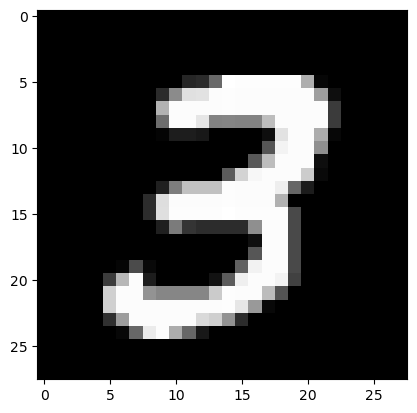

In [13]:
plt.imshow(X_real[0].squeeze(), cmap = "gray");

> label이 하나밖에 없으니까 일단 판별 목적은 아님...

### **B. 페이커 생성 $\to$ 일단 선언만 함**

> `net_faker` : noise $\to$ 가짜 이미지를 만들자. 잡다한 숫자들로 가짜 이미지를 만들자...

`-` 네트워크의 입력 : (n, ??)인 랜덤으로 뽑은 숫자

In [14]:
torch.randn(1, 4) ## 노이즈

tensor([[-0.9674,  0.0062, -0.3523,  0.7320]])

`-` 네트워크의 출력 : (n, 1, 28, 28)의 텐서

In [15]:
28*28

784

In [28]:
class FlattenToImage(torch.nn.Module) :
    def __init__(self) :
        super().__init__()

    def forward(self, x) :
        return x.reshape(-1, 1, 28, 28) ## 여러 observation이 존재할 수 있으니까 -1...

net_faker = torch.nn.Sequential(
    torch.nn.Linear(4, 64), ## 한번에 변환하면 너무 팍 변하니까...
    torch.nn.ReLU(), ## 렐루 넣어서 변환을 더 복잡하게
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 784),
    torch.nn.Sigmoid(), ## 단순히 출력을 0~1로 눌러주기 위한 레이어
    FlattenToImage()
)

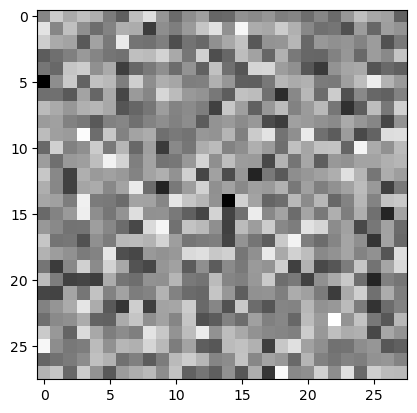

In [29]:
plt.imshow(net_faker(torch.randn(1, 4)).squeeze().data, cmap = "gray");

> 얘를 최대한 3의 모양과 비슷하도록 가중치를 학습해야 함 ㅇㅇ

### **C. 경찰 생성**

> `net_police` : 진짜 이미지 $\to$ 0 // 가짜이미지 $\to$ 1과 같은 판별모형

`-` 네트워크의 입력 : (n, 1, 28, 28)의 이미지

`-` 네트워크의 출력 : 0 또는 1(가짜 이미지 타겟)

In [32]:
torch.nn.Flatten()(net_faker(torch.randn(1, 4))).shape

torch.Size([1, 784])

In [33]:
net_police = torch.nn.Sequential(
    torch.nn.Flatten(), ## CNN 말고 간단한 이미지 분류하는 신경망으로 설계
    torch.nn.Linear(784, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid()
)

In [36]:
net_police(X_real[0]) ## 얘는 0 근처로 나와야 함

tensor([[0.4848]], grad_fn=<SigmoidBackward0>)

In [39]:
net_police(net_faker(torch.randn(1, 4))) ## 얘는 1 근처로 나와야 함

tensor([[0.5080]], grad_fn=<SigmoidBackward0>)

> 이런 두 개 이미지 중 하나가 들어가게 됨. 아직 학습은 하나도 안되어서 분류 못함

### **D. 바보 경찰, 바보 페이커 $\to$ 학습 전**

`-` 데이터

In [44]:
real_image = X_real[[0]]
fake_image = net_faker(torch.randn(1, 4)).data ## 이미지니까, 그래디언트 붙으면 안되지

`-` 경찰 네트워크가 가짜 이미지를 봤을 때 어떤 판단을 하는지, 진짜 이미지를 봤을 때 어떤 판단을 하는지 살펴보자

***<경찰이 진짜 이미지를 봤다면>***

In [45]:
net_police(real_image)

tensor([[0.4848]], grad_fn=<SigmoidBackward0>)

***<경찰이 가짜 이미지를 봤다면>***

In [46]:
net_police(fake_image)

tensor([[0.5078]], grad_fn=<SigmoidBackward0>)

> 영 아쉬움... -> 당연히 아직 학습이 안됐으니까...

### **E. 똑똑해진 경찰 - 1차 식별자 학습**

* `X = (진짜이미지, 가짜이미지, 진짜이미지, ...)`
* `y = (0, 1, 0, ...)`

> 그냥 DNN이든 CNN이든 일단 잘 분류하는 모형이면 됨!

`-` fake image : real image = 1 : 1

In [55]:
X_real.shape

torch.Size([6131, 1, 28, 28])

In [58]:
X_fake = net_faker(torch.randn(6131, 4)).data ## 미분꼬리표가 결과에 영향을 미치면 안됨...

y_real = torch.zeros((6131, 1))
y_fake = torch.ones((6131, 1))

`X_real, X_fake`는 합치려고 했지만... 어떤 이유로 일단 내버려둠

-   원래 $n=6131$개의 이미지자료가 있었음. 이를 ${\bf X}_{real}$ 로
    저장했었음.
-   ${\bf X}_{fake}$는 `net_facker`의 output으로 생성하고 꼬리표 제거.
-   ${\bf X}_{real}$에 대응하는 ${\bf y}_{real}$ 생성. 진짜이미지는
    라벨을 0으로 정함.
-   ${\bf X}_{faker}$에 대응하는 ${\bf y}_{fake}$ 생성. 가짜이미지는
    라벨을 1로 정함. (라벨을 어떻게 정하는지는 딱히 상관 없음)

`-` Step 1 : `X_real`, `X_fake`를 보고 각각 `yhat_real`, `yhat_fake`를 만드는 과정

In [61]:
yhat_real = net_police(X_real)
yhat_fake = net_police(X_fake)

`-` Step 2 : 손실을 계산 - `net_police`는 가짜이미지를 가짜라고 하고, 진짜 이미지를 진짜라고 해야 함 $\to$ `yhat_real`은 거의 0의 값으로, `yhat_fake`는 거의 1의 값이 되도록 설계해야 함.

In [62]:
bce = torch.nn.BCELoss()

loss_police = bce(yhat_real, y_real) + bce(yhat_fake, y_fake) ## /2 해야 전체랑 똑같긴 한데, 그정도는...
loss_police

tensor(1.3269, grad_fn=<AddBackward0>)

`-` Step 3~4

In [84]:
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid()
)


bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police.parameters())

##---##
for epoc in range(30) :
    X_fake = net_faker(torch.randn(6131, 4)).data ## 훈련 데이터를 계속 무작위 생성
    
    yhat_real = net_police(X_real)
    yhat_fake = net_police(X_fake)

    loss_police = bce(yhat_real, y_real) + bce(yhat_fake, y_fake)
    loss_police.backward()

    optimizr_police.step()
    optimizr_police.zero_grad()

In [89]:
(net_police(X_real) > 0.5).float().mean().item()

0.0

In [93]:
(net_police(net_faker(torch.randn(6131, 4))).data > 0.5).float().mean().item()

1.0

> 이정도면 신경망 주제에 매우 우수함

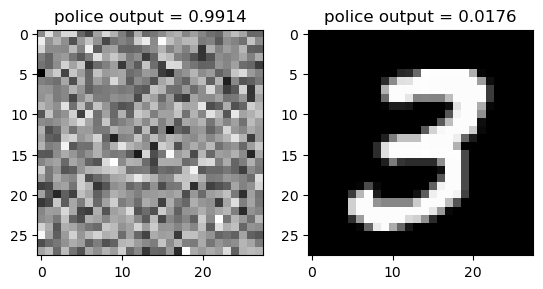

In [99]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_fake[[0]].squeeze(), cmap = "gray")
ax[0].set_title(f"police output = {net_police(X_fake[[0]]).item():.4f}")
ax[1].imshow(X_real[[0]].squeeze(), cmap = "gray")
ax[1].set_title(f"police output = {net_police(X_real[[0]]).item():.4f}");

### **F. 더 똑똑해지는 페이커**

`-` Step 1 : noise $\to$ X_fake